[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass
from dotenv import load_dotenv

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

load_dotenv("../.env")

True

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [2]:
# _set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = os.getenv("langchain_api_key")
os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("langchain_tracing_v2")
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Souvik"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Souvik

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [4]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o")
# llm.invoke(messages)

from langchain_openai import AzureChatOpenAI

llm = AzureChatOpenAI(
    deployment_name = os.getenv("deployment_name"),
    model_name = os.getenv("model_name"),
    azure_endpoint = os.getenv("azure_endpoint"),
    openai_api_key = os.getenv("openai_api_key"),
    openai_api_version = os.getenv("openai_api_version"),
    temperature = 0)

We can run our chat model in a simple graph with `MessagesState`.

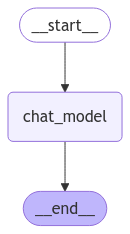

In [5]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Souvik

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: These intelligent and social creatures are known for their playful behavior and complex communication skills. There are many species of dolphins, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have different physical characteristics, such as a more rounded snout and spade-shaped teeth.

3. **Seals**: These marine mammals are part of the pinniped family, which also includes sea lions and walruses. Sea

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

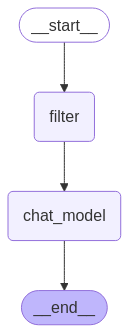

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Souvik", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Souvik", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Souvik

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures, porpoises are also interesting marine mammals.

3. **Seals**: There are various species of seals, including harbor seals and elephant seals. They are known for their ability to live both in water and on land.

4. **Sea Lions**: Often confused with seals, sea

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

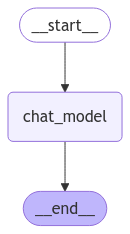

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Souvik"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Souvik

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Souvik

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures, porpoises are also interesting marine mammals.

3. **Seals**: T

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Souvik

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Souvik

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:

1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.

2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures, porpoises are also interesting marine mammals.

3. **Seals**: T

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/4f50372e-755b-4f87-8b29-575accf4dfd8/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

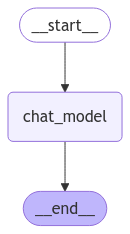

In [33]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens = 600,
            strategy = "last",
            token_counter = llm,
            allow_partial = False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Souvik"))

In [38]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Souvik', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Souvik', id='4'),
 AIMessage(content="That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:\n\n1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures, porpoises are also interesting marine mammals.\n\n3. **Seals**: There are various species of seals, including harbor seals and elephant

In [39]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=800,
            strategy="last",
            token_counter=llm,
            allow_partial=False
        )

[HumanMessage(content='Tell me more about Narwhals!', additional_kwargs={}, response_metadata={}, name='Souvik', id='8655b8ba-0b38-44e6-aeb8-9171357a72f1'),
 AIMessage(content='Narwhals (Monodon monoceros) are fascinating marine mammals known for their distinctive long, spiral tusks that protrude from their heads. Here are some key points about narwhals:\n\n### Physical Characteristics:\n1. **Tusks**: The most notable feature of narwhals is the long tusk, which is actually an elongated upper left canine tooth. In males, this tusk can grow up to 10 feet (3 meters) long. Some females also have tusks, but they are usually shorter and less common.\n2. **Size**: Narwhals are medium-sized whales, with males typically reaching lengths of 13-18 feet (4-5.5 meters) and females being slightly smaller.\n3. **Coloration**: They have a mottled black and white coloration, which helps them blend into their Arctic environment.\n\n### Habitat:\n- Narwhals are primarily found in the Arctic waters around

In [40]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [41]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Souvik', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Souvik', id='4'),
  AIMessage(content="That's great that you know about whales! There are many other fascinating ocean mammals you can learn about. Here are a few:\n\n1. **Dolphins**: Highly intelligent and social animals, dolphins are known for their playful behavior and complex communication skills.\n\n2. **Porpoises**: Similar to dolphins but generally smaller and with different facial structures, porpoises are also interesting marine mammals.\n\n3. **Seals**: There are various species of seals, including harbor s

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/2f9903da-b411-4494-a87d-677a7abd3591/r